In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# load in ensemble to gene name dictionary (mm10)
#gene_map = '/oasis/tscc/scratch/biom200/bms_2019/annotations/mm10/mouse_names.txt'
gene_map = '/oasis/tscc/scratch/biom200/bms_2019/annotations/mm10/gene_names_mm10.txt'
gene = pd.read_table(gene_map)
geneDict = dict(zip(gene.gene_id, gene.gene_name))

# load in clean counts matrix
counts_file = '/oasis/tscc/scratch/biom200/bms_2019/rna_seq/analysis/feature_counts/Mouse_LPS_clean_counts_with_length.csv'
counts = pd.read_csv(counts_file, index_col=0)

counts.index = counts.index.to_series().map(geneDict) # use the dictionary to convert ensemble ids to gene names
counts.columns = counts.columns.str.replace('_',' ')

# TPM normalization
# https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/
counts_norm = counts.div(counts['Length'], axis=0) # normalize by gene length
counts_norm = counts_norm / counts_norm.sum(axis=0) * 1e6 # normalize by library size to 1M reads
counts_norm.drop('Length', axis=1, inplace=True) # we don't need the length column any more

# load in deseq results
res_file = '/oasis/tscc/scratch/biom200/bms_2019/rna_seq/analysis/deseq2/dendritic_differential_expression.csv'
res = pd.read_csv(res_file, index_col=0)
res_filt = res.dropna() # drop rows that contain NaN
res_filt = res_filt.loc[~pd.isnull(res_filt.index)] # drop indexes that contain NaN
res_filt = res_filt.sort_values('pvalue') #sort by the p-value columns
res_filt.index = res_filt.index.to_series().map(geneDict) # use the dictionary to convert ensemble ids to gene names

counts_norm.head()

/home/jschmok/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


,mouse 0hr rep1,mouse 0hr rep2,mouse 4hr rep1,mouse 4hr rep2
Geneid,,,,
Gm6085,0.000000,0.337938,0.164966,1.029000
Gm6123,0.825946,0.929410,0.680541,1.741533
Mrpl15,10.108628,10.613984,3.814504,4.716215
Gm37144,1.663502,0.431974,0.210869,0.202359
Lypla1,16.558908,11.518287,9.027977,11.252918


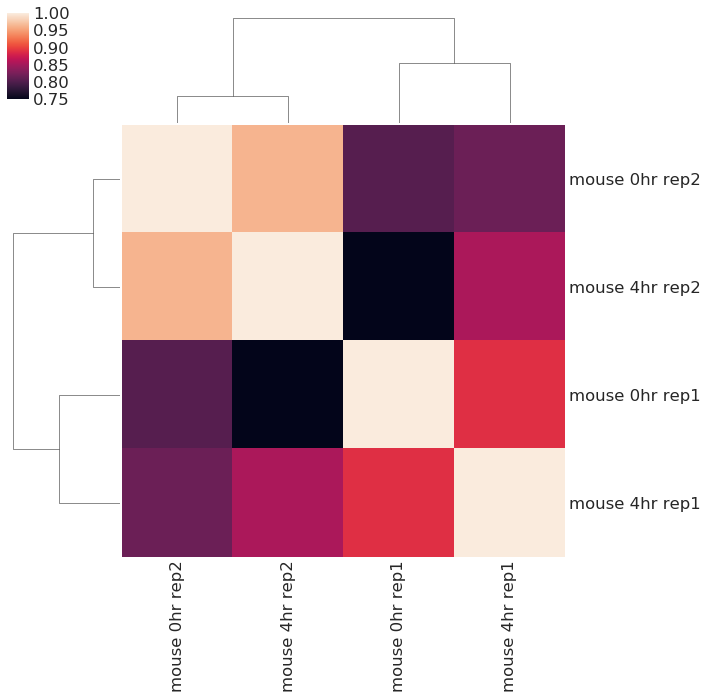

In [14]:
# basic correlation plot 

sns.clustermap(counts_norm.corr())

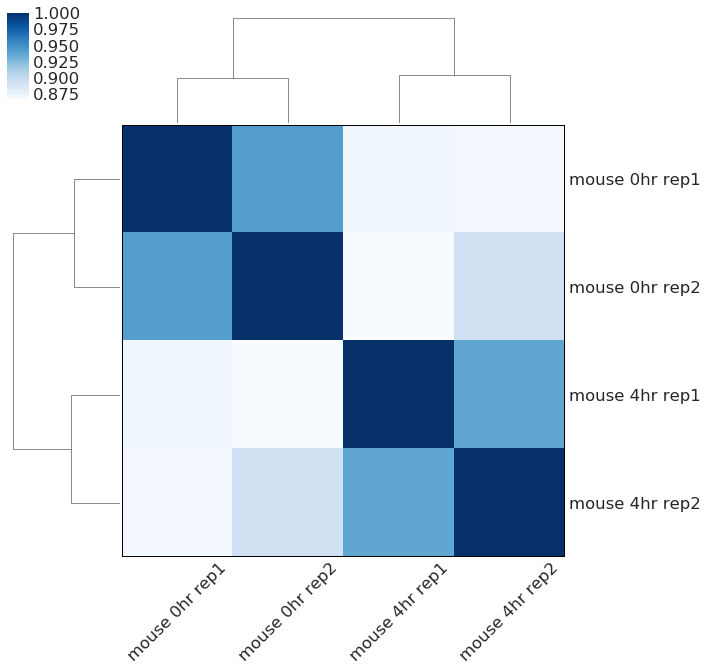

In [15]:
sns.set(font_scale=1.5) # easy way to make fonts bigger
plt.style.use('seaborn-white') # use a styling theme
# use spearman correlation, which is less biased towards outliers
cm = sns.clustermap(counts_norm.corr(method='spearman'), cmap='Blues')

# aesthetics
cm.ax_heatmap.set_xticklabels(cm.ax_heatmap.get_xticklabels(), rotation=45, ha='center') # rotate x tick label
cm.ax_heatmap.axvline(0, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axvline(4, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axhline(0, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axhline(4, color='black', lw=2) # make a frame around the heatmap

plt.show()

In [17]:
# get the counts of the top 50 differentially expressed genes
res_top50 = res_filt.head(50) # subset for the top 50 most significant genes 
res_top50
top50_genes = res_top50.index # we just want the gene names
top50_genes
counts_norm.head()
res_top50.head()
top50_counts = counts_norm.loc[top50_genes] # get the normalized counts of the top 50 genes

In [18]:
top50_genes

Index(['Il6', 'Tnfsf15', 'Acod1', 'Oasl1', 'Cxcl10', 'Il12b', 'Ptgs2', 'Il1b',
       'Ifit1', 'Inhba', 'Tnf', 'Ifi211', 'Cxcl2', 'Nfkbiz', 'Rsad2', 'Cd40',
       'Ccrl2', 'Isg15', 'Ifit2', 'Cxcl3', 'Ifih1', 'Gbp5', 'Saa3', 'Ifi206',
       'Ccl4', 'Il1a', 'Ifi44', 'Ifi203', 'Il27', 'Htra4', 'Clec4e', 'Mndal',
       'Cxcl1', 'Iigp1', 'Mir155hg', 'Ccl3', 'Tnfaip3', 'Mx2', 'Ccl5',
       'Parp14', 'Il1bos', 'Ifit3', 'Gm6093', 'Met', 'Gadd45b', 'Hdc',
       'Zc3h12c', 'B230303A05Rik', 'Sdc4', 'Ptx3'],
      dtype='object')

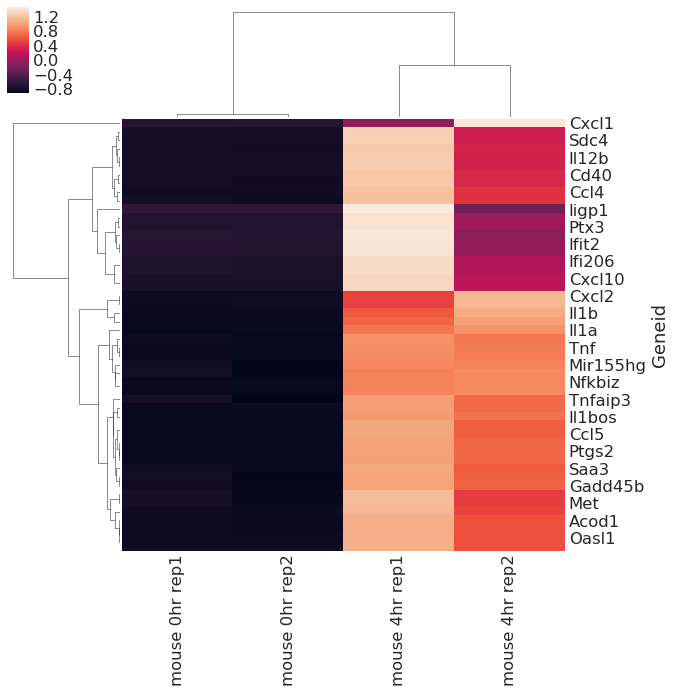

In [19]:
# make a barebones clustermap

sns.clustermap(top50_counts, z_score=0)

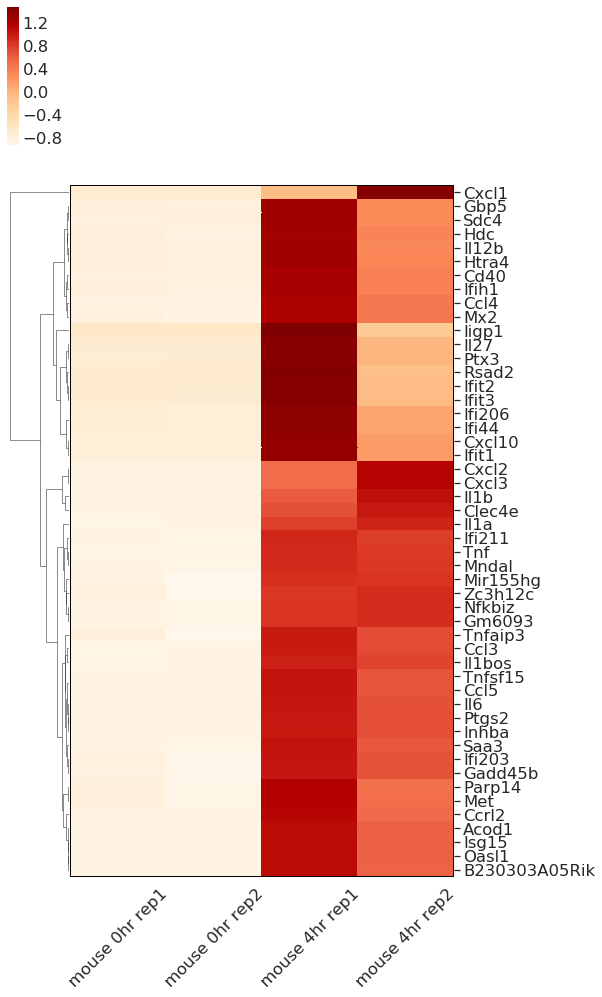

In [20]:
# make a pretty clustermap
cm = sns.clustermap(top50_counts, z_score=0,
                    col_cluster=False, yticklabels=1, 
                    cmap='OrRd', figsize=(8,16)) 

# aesthetics
cm.ax_heatmap.tick_params(axis='both', length=6, width=1.25) # turn axis ticks back on, sns.set turns it off
cm.ax_heatmap.set_xticklabels(cm.ax_heatmap.get_xticklabels(), rotation=45, ha='center') # rotate x tick labels
cm.ax_heatmap.set_ylabel('') # turn off y axis label

cm.ax_heatmap.axvline(0, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axvline(len(top50_counts.columns), color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axhline(0, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axhline(len(top50_counts), color='black', lw=2) # make a frame around the heatmap

plt.show()

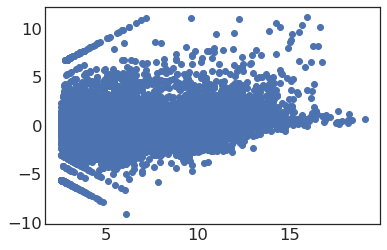

In [21]:
# make a MA plot

plt.scatter(np.log2(res_filt['baseMean']), res_filt['log2FoldChange'])

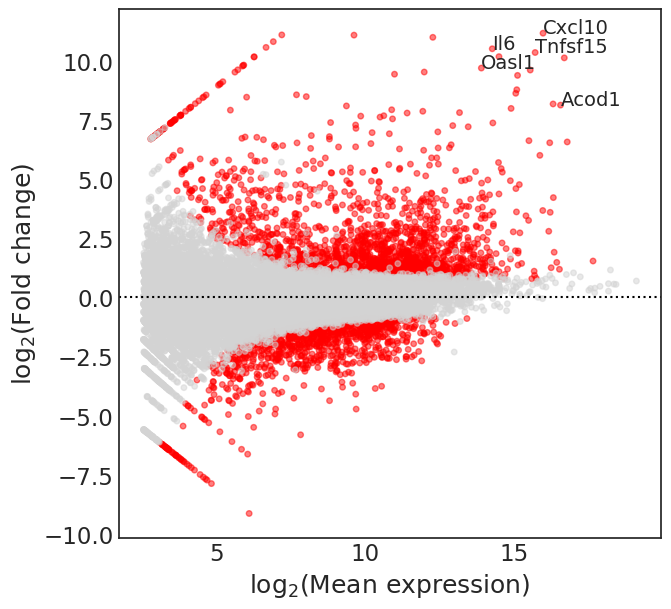

In [22]:
# make a prettier MA plot

pval_threshold = 0.05
cond = ['red' if p < pval_threshold else 'lightgrey' for p in res_filt['padj']] # set a coloring condition

fig, ax1 = plt.subplots(1,1, figsize=(7,7), dpi=100) # controls parameters about number of subplots (e.g. multiple grid plot)
ax1.scatter(np.log2(res_filt['baseMean']), res_filt['log2FoldChange'], color=cond, s=16, alpha=.5) # use smaller points

ax1.set_xlabel('log$_2$(Mean expression)') # set xlabel
ax1.set_ylabel('log$_2$(Fold change)') # set ylabel
ax1.axhline(0, color='black', linestyle='dotted') # make a horizontal dotted line at 0

# label the 5 top hits
for i,row in res_filt.head(5).iterrows():
    ax1.text(np.log2(row['baseMean']), row['log2FoldChange'], row.name, ha='left', fontsize=14)

plt.show()
